# <center> 1. Gradient Descent </center>

- Gradiend Descent methods realisation (basic, heavy-ball, Nesterov's);
- Testing methods;
- Testing Nesterov's methods convergence on different starting areas.

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib as plt
import matplotlib.pyplot as plt
from tqdm import tqdm

In [2]:
##### Jupyter notebook theme setup:
# !pip install jupyterthemes
!jt -t gruvboxd -fs 95 -tfs 11 -nfs 115 -cellw 80% -T
##### Reset theme:
# !jt -r
##### Plot style:
from jupyterthemes import jtplot
jtplot.style()

# Reload page after cell evaluation

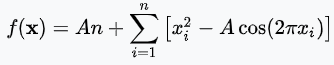

### Function and gradient

In [3]:
def f(x: pd.Series, A=10) -> float:
    n = x0.size
    cos_s = (2 * np.pi * x).map(np.cos)
    s = (x ** 2 - A * cos_s)
    return A * n + s.sum()


def f_nabla(x: pd.Series, A=10) -> float:
    sin_s = (2 * np.pi * x).map(np.sin)
    s = (2 * x + 2 * np.pi * A * sin_s)
    return s

### Input parameters

In [5]:
# Function parameters
A = 10
n = 2

# Algorithm parameters
x0 = pd.Series([np.random.rand() * 50 - 25, np.random.rand() * 50 - 25])
print(x0)
alpha = 0.01
gamma = 0.25
iterations = 100

# NB! Optimal parameters for each of methods could differ 

0    -4.077829
1    22.365346
dtype: float64


### Gradient Descent

In [6]:
def grad_desc(f_nabla, x0: pd.Series,
              alpha=0.01, it=10**4, eps=10**-4, A=10) -> pd.Series:
    trace = [x0.values]
    x = x0.copy()
    
    for cut_it in range(it):
        step = -1 * alpha * f_nabla(x, A=A)
        x += step
        trace.append(x.copy())
        if np.linalg.norm(step) <= eps:
            break
    
    return pd.Series(trace)


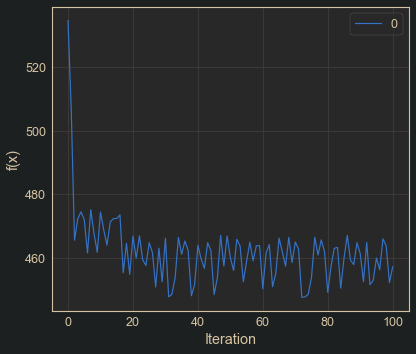

In [7]:
p = pd.DataFrame(grad_desc(f_nabla, x0, alpha=alpha, it=iterations, A=A).map(lambda t: f(pd.Series(t)))).plot.line();
p.set_xlabel("Iteration");
p.set_ylabel("f(x)");

### Heavy-ball GD

In [8]:
def grad_desc_hb(f_nabla, x0: pd.Series,
                 alpha=alpha, gamma=gamma, it=10**4, eps=10**-4, A=A) -> pd.Series:
    trace = [x0.values]
    x = x0.copy()
    prev_step = pd.Series([0, 0])
    
    for cut_it in range(it):
        cur_step = gamma * prev_step - 1 * alpha * f_nabla(x, A=A)
        prev_step = cur_step.copy()
        x += cur_step
        trace.append(x.copy())
        if np.linalg.norm(cur_step) <= eps:
            break
    
    return pd.Series(trace)


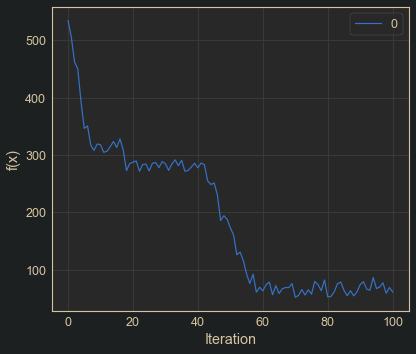

In [9]:
p = pd.DataFrame(grad_desc_hb(f_nabla, x0, alpha, gamma, it=iterations).map(lambda t: f(pd.Series(t)))).plot.line();
p.set_xlabel("Iteration");
p.set_ylabel("f(x)");

### Nesterov's GD

In [10]:
def grad_desc_nesterov(f_nabla, x0: pd.Series,
                       alpha=alpha, gamma=gamma, it=10**4, eps=10**-4, A=A):
    trace = [x0.values]
    x = x0.copy()
    prev_step = pd.Series([0, 0])
    
    for cut_it in range(it):
        cur_step = gamma * prev_step - 1 * alpha * f_nabla(x + gamma * prev_step, A=A)
        prev_step = cur_step.copy()
        x += cur_step
        trace.append(x.copy())
        if np.linalg.norm(cur_step) <= eps:
            break
    
    return pd.Series(trace)


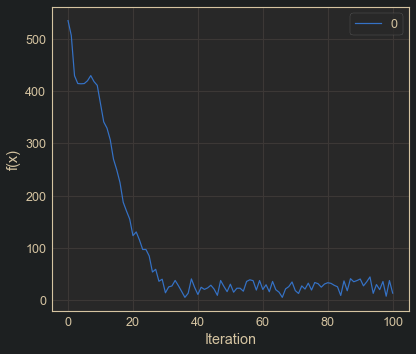

In [11]:
p = pd.DataFrame(grad_desc_nesterov(f_nabla, x0, alpha, gamma, it=iterations).map(lambda t: f(pd.Series(t)))).plot.line();
p.set_xlabel("Iteration");
p.set_ylabel("f(x)");

### Evaluation

In [12]:
test_res = [
    grad_desc(f_nabla, x0, alpha, it=iterations).map(lambda t: f(pd.Series(t)))
    , grad_desc_hb(f_nabla, x0, alpha, gamma, it=iterations).map(lambda t: f(pd.Series(t)))
    , grad_desc_nesterov(f_nabla, x0, alpha, gamma, it=iterations).map(lambda t: f(pd.Series(t)))
]

In [13]:
df_res = pd.DataFrame(test_res, index=['GD', 'Heavy-Ball', 'Nesterov']).transpose().fillna(0)

Text(0, 0.5, 'f(x)')

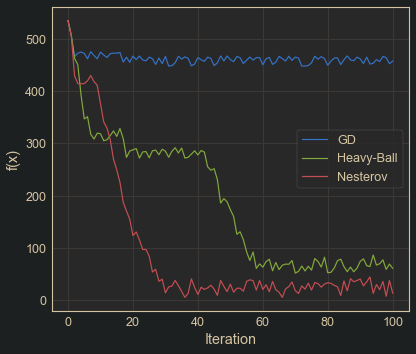

In [14]:
# All methods are reaching ~0 extremum
# But Nesterov does it a little bit faster

p = df_res.plot.line()
p.set_xlabel("Iteration")
p.set_ylabel("f(x)")

### Most probable global extremum

In [15]:
# Lets take Nesterov's method as base
# and redefine it to have only one point on output
# that is the best one among all iterations.

def grad_desc_nesterov_no_tail(f, f_nabla, x0: pd.Series,
                               alpha=alpha, gamma=gamma, it=10**4, eps=10**-3, A=A):
    x = x0.copy()
    x_best = x.copy()
    f_best = f(x_best, A=A)
    prev_step = pd.Series([0, 0])
    
    for cut_it in range(it):
        cur_step = gamma * prev_step - 1 * alpha * f_nabla(x + gamma * prev_step, A=A)
        prev_step = cur_step.copy()
        x += cur_step
        if f_best > f(x, A=A):
            x_best = x.values
            f_best = f(x, A=A)
        if np.linalg.norm(cur_step) <= eps:
            break
    
    return x_best


In [16]:
np.random.rand(2) * 50 - 25

array([ 13.76837658, -12.23718547])

In [17]:
# random start point model

def get_minimum_pr(f, f_nabla, alpha, gamma, it=10**3, point_bounds=[-30, 30], method_it=10**3, n=2):
    points = []
    for _ in tqdm(range(it)):
        x0 = pd.Series(np.random.rand(n) * (point_bounds[1] - point_bounds[0]) + point_bounds[0])
        cur_point = grad_desc_nesterov_no_tail(f, f_nabla, x0, alpha, gamma, it=method_it)
        points.append(cur_point.copy())
    return points

In [18]:
gen_points = get_minimum_pr(f, f_nabla, alpha, gamma, it=100, method_it=10 ** 2, point_bounds=[-20, 20])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:28<00:00,  3.53it/s]


In [19]:
gen_df = pd.DataFrame(map(lambda t: [t[0], t[1], f(pd.Series(t))], gen_points), columns=['x', 'y', 'f'])

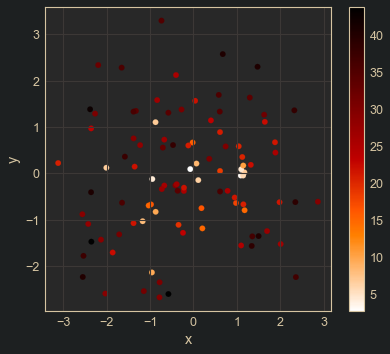

In [20]:
# Result points are plottet and colored with respect to value of f
plt.scatter(gen_df['x'], gen_df['y'], c=gen_df['f'], cmap=plt.get_cmap('gist_heat').reversed());

plt.xlabel('x');
plt.ylabel('y');

plt.colorbar()

plt.show();

What if we are not able to find area of extremum point? (and also out random point area is far away)

In [21]:
gen_points_2 = get_minimum_pr(f, f_nabla, alpha, gamma, it=100, method_it=350, point_bounds=[-100, -200])

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [01:35<00:00,  1.05it/s]


In [22]:
gen_df_2 = pd.DataFrame(map(lambda t: [t[0], t[1], f(pd.Series(t))], gen_points_2), columns=['x', 'y', 'f'])

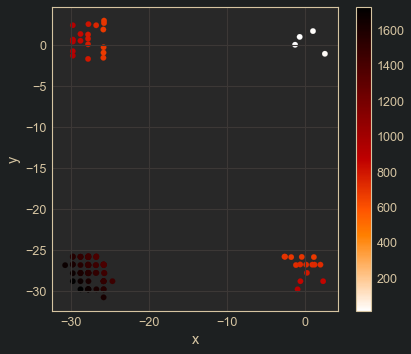

In [23]:
plt.scatter(gen_df_2['x'], gen_df_2['y'], c=gen_df_2['f'], cmap=plt.get_cmap('gist_heat').reversed());

plt.xlabel('x');
plt.ylabel('y');

plt.colorbar()

plt.show();

Results:
1. Nesterov's method is nice;
2. It gives nice prescicion for random points if extremum is localized;
3. Even if it is not, a lot of random points allow it to reach extremum area.